In [122]:
# https://www.analyticsvidhya.com/blog/2021/07/stock-market-forecasting-using-time-series-analysis-with-arima-model/
# Importation des packages nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm


In [123]:

# 1. Chargement et préparation des données
# Remplacez 'df_btc.csv' par le chemin de votre fichier CSV
df = pd.read_csv("CSV/df_sp500.csv", 
                 sep=',',
                 index_col='Date',
                 parse_dates=["Date"], 
                 dayfirst=True)

df = df.sort_values("Date")
df.tail()


,Close,High,Low,Open,Volume
Date,,,,,
2025-02-05,6061.479980,6062.859863,6007.060059,6020.450195,4756250000
2025-02-06,6083.569824,6084.029785,6046.830078,6072.220215,4847120000
2025-02-07,6025.990234,6101.279785,6019.959961,6083.129883,4766900000
2025-02-10,6066.439941,6073.379883,6044.839844,6046.399902,4458760000
2025-02-11,6068.500000,6076.279785,6042.339844,6049.319824,4324880000


In [124]:
#drop unnamed columns
df.drop(df.columns[df.columns.str.contains(
    'unnamed', case=False)], axis=1, inplace=True)
df

,Close,High,Low,Open,Volume
Date,,,,,
2020-02-12,3379.449951,3381.469971,3369.719971,3370.500000,3930910000
2020-02-13,3373.939941,3385.090088,3360.520020,3365.899902,3500890000
2020-02-14,3380.159912,3380.689941,3366.149902,3378.080078,3419700000
2020-02-18,3370.290039,3375.010010,3355.610107,3369.040039,3750400000
2020-02-19,3386.149902,3393.520020,3378.830078,3380.389893,3614200000
...,...,...,...,...,...
2025-02-05,6061.479980,6062.859863,6007.060059,6020.450195,4756250000
2025-02-06,6083.569824,6084.029785,6046.830078,6072.220215,4847120000
2025-02-07,6025.990234,6101.279785,6019.959961,6083.129883,4766900000


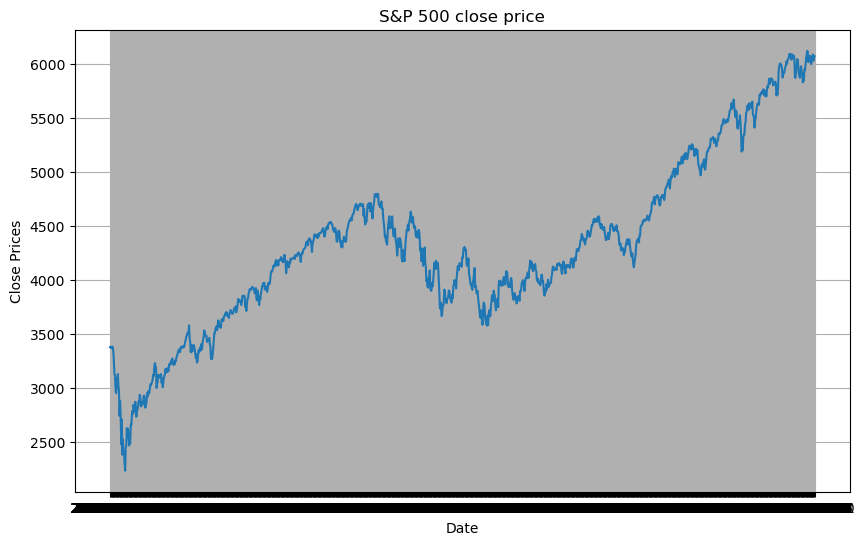

In [125]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('S&P 500 close price')
plt.show()

count    1257.000000
mean     4318.542141
std       793.743583
min      2237.399902
25%      3854.429932
50%      4255.149902
75%      4688.669922
max      6118.709961
Name: Close, dtype: float64

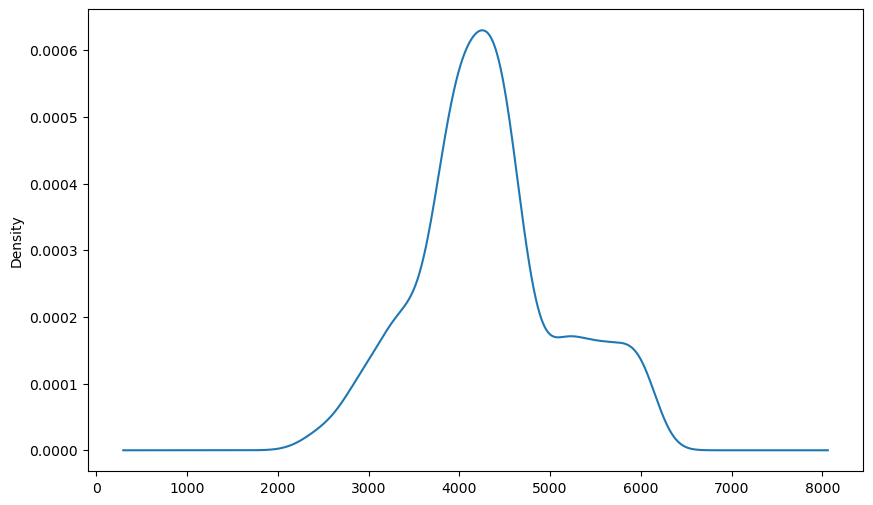

In [126]:
#Distribution of the dataset
df_close = df['Close']
df_close.plot(kind='kde')
df_close.describe()

<Figure size 1000x600 with 0 Axes>

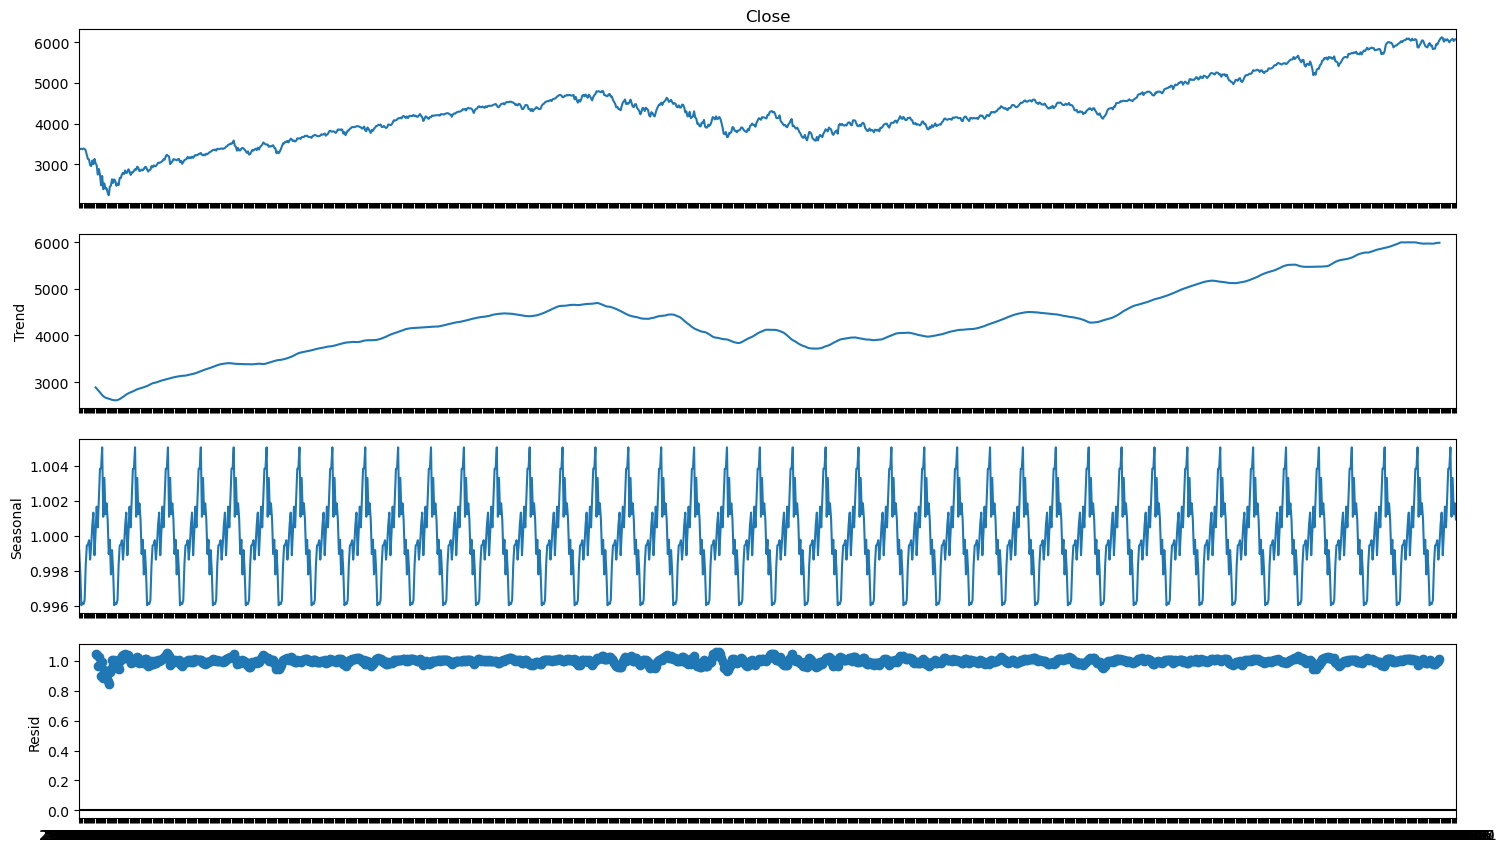

In [136]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

<Figure size 1000x600 with 0 Axes>

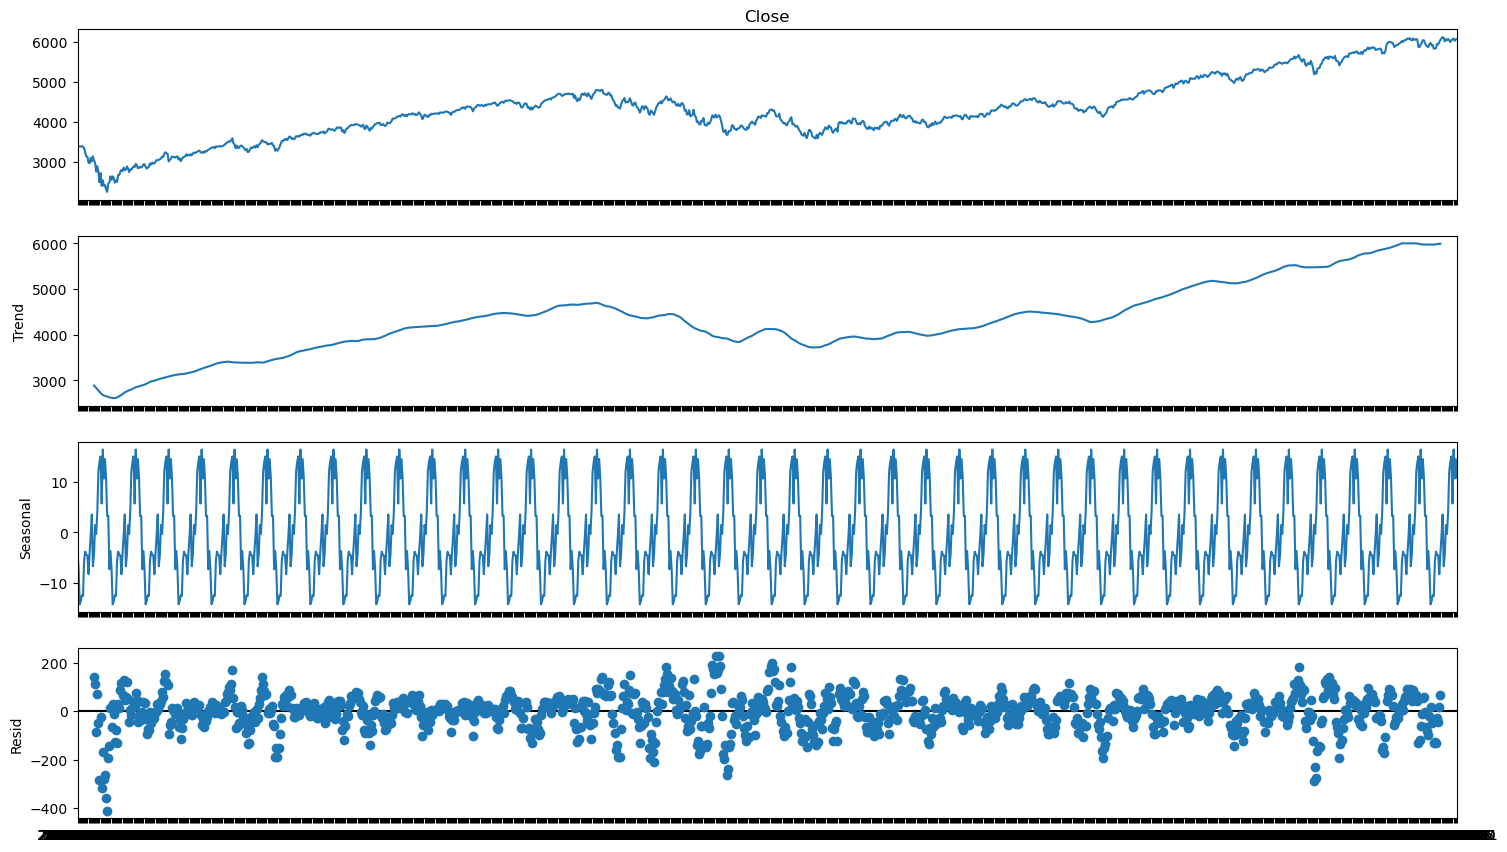

In [137]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='additive', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

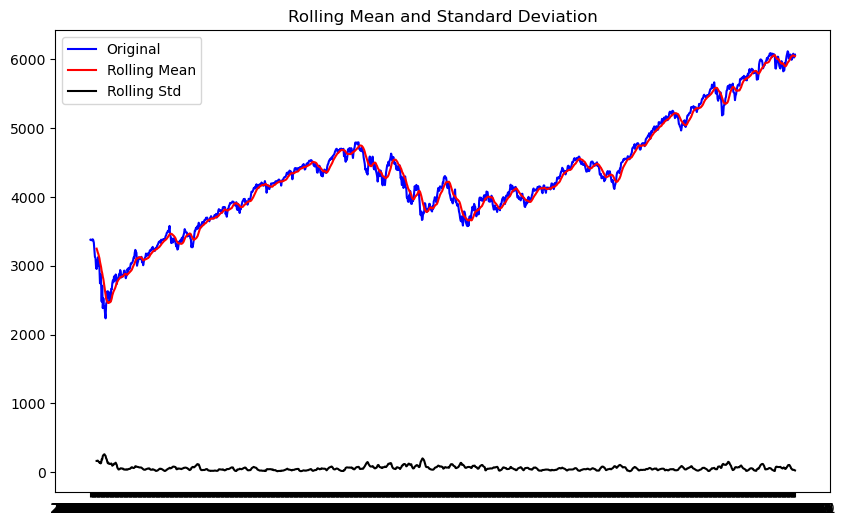

Results of dickey fuller test
Test Statistics                  -0.461511
p-value                           0.899311
No. of lags used                 10.000000
Number of observations used    1246.000000
critical value (1%)              -3.435609
critical value (5%)              -2.863862
critical value (10%)             -2.568006
dtype: float64


In [127]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

La série temporelle n'est pas stationnaire car il la p-value est plus grande que 0.05. 

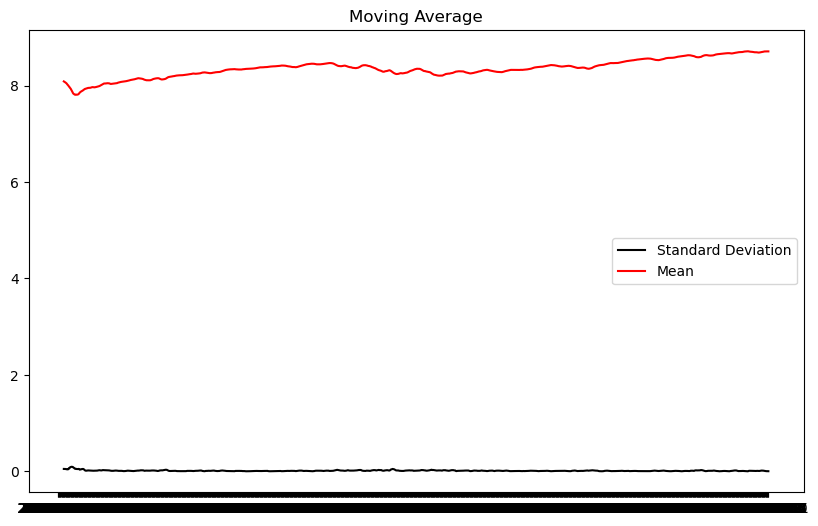

In [128]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

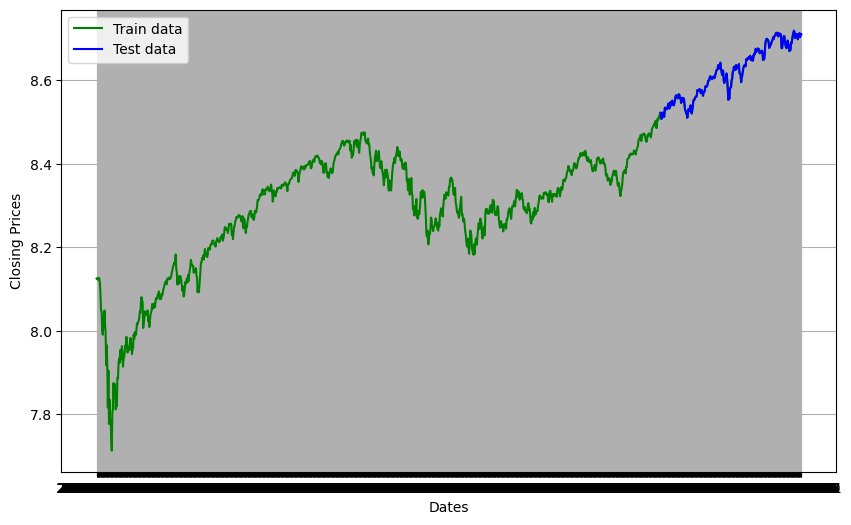

In [129]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.8)], df_log[int(len(df_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5620.916, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5657.929, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5650.140, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5622.186, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-5668.028, Time=0.24 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-5666.392, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5665.845, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5663.154, Time=0.20 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5664.176, Time=0.20 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-5669.159, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-5658.850, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-5667.555, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-5666.944, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-5664.147, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0

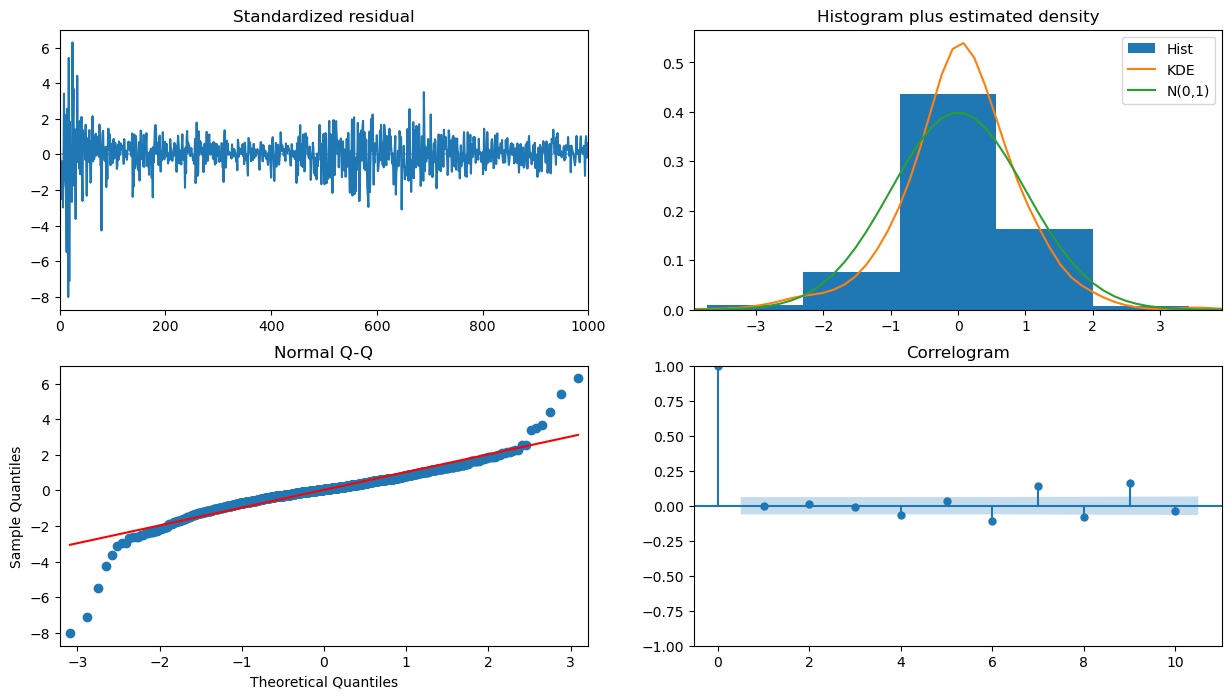

In [130]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [131]:
#As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.

#Modeling
# Build Model
model = ARIMA(train_data, order=(2,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1002
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2837.579
Date:                Wed, 12 Feb 2025   AIC                          -5669.159
Time:                        14:52:22   BIC                          -5654.433
Sample:                             0   HQIC                         -5663.562
                               - 1002                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1731      0.014    -12.241      0.000      -0.201      -0.145
ar.L2          0.1107      0.013      8.297      0.000       0.085       0.137
sigma2         0.0002   3.72e-06     54.227      0.0

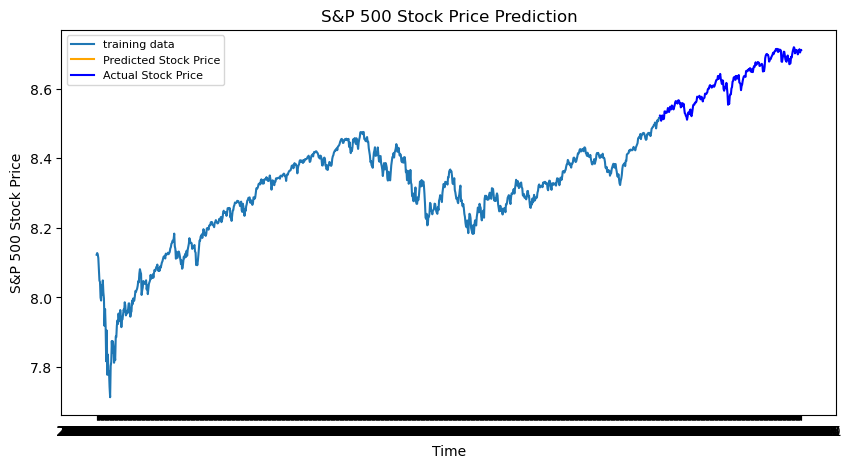

In [142]:
# Forecast
fc = fitted.forecast(321, alpha=0.05)  # 95% conf
conf = fitted.get_forecast(321).conf_int(alpha=0.05)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('S&P 500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P 500 Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [141]:
len(fc_series)

252

In [134]:
# Align the lengths of test_data and fc
aligned_test_data = test_data[:len(fc)]
aligned_fc = fc[:len(aligned_test_data)]

# Convert test data to numpy array for comparison
test_np = aligned_test_data.values
forecast_np = aligned_fc.values

# Calculate performance metrics
mse = mean_squared_error(test_np, forecast_np)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_np, forecast_np)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_np, forecast_np))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(forecast_np - test_np)/np.abs(test_np))
print('MAPE: '+str(mape))

MSE: 0.014309998468284409
MAE: 0.10269109381128216
RMSE: 0.11962440582207466
MAPE: 0.011862669190290352
